# Extreme Precipitation Events -- Group Sunshine 

We investigate the change in the rate of daily extreme precipitation events with CO2 concentration.

- Here are some sections to calculate the extreme precipitation event rate first. 
- Then the key plots and global maps are created.

We loaded both the LGM and PI ice configurations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import time
import cartopy.crs as ccrs
import cartopy
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset

file52 = Dataset("data/exp52_i0_o1_c185.nc")
pr185_LGM = file52.variables["pr"][:]
t185_LGM  = file52.variables["time"][:]
lat       = file52.variables["lat"][:]
lon       = file52.variables["lon"][:]

file62 = Dataset("data/exp62_i0_o1_c280.nc")
pr280_LGM = file62.variables["pr"][:]
t280_LGM  = file62.variables["time"][:]

file92 = Dataset("data/exp92_i0_o1_c560.nc")
pr560_LGM = file92.variables["pr"][:]
t560_LGM  = file92.variables["time"][:]

fileCO1 = Dataset("data/CO2_185.nc")
pr185_PI = fileCO1.variables["pr"][:]
t185_PI  = fileCO1.variables["time"][:]

fileCO2 = Dataset("data/CO2_280.nc")
pr280_PI = fileCO2.variables["pr"][:]
t280_PI  = fileCO2.variables["time"][:]

fileCO3 = Dataset("data/CO2_560.nc")
pr560_PI = fileCO3.variables["pr"][:]
t560_PI  = fileCO3.variables["time"][:]

In [2]:
# implement calculation of mean and std in function
def mean_std(pr):
    mean = np.mean(pr,axis=0)
    std = np.std(pr,axis=0)
    return mean, std

mean185_LGM, std185_LGM = mean_std(pr185_LGM)
mean280_LGM, std280_LGM = mean_std(pr280_LGM)
mean560_LGM, std560_LGM = mean_std(pr560_LGM)
mean185_PI, std185_PI = mean_std(pr185_PI)
mean280_PI, std280_PI = mean_std(pr280_PI)
mean560_PI, std560_PI = mean_std(pr560_PI)

# control output
print(np.shape(mean280_LGM))
print(np.shape(std280_LGM))

(32, 64)
(32, 64)


In [3]:
np.shape(pr280_LGM[:,0,0])

(3652,)

In [4]:
treshold_factor=5

def count_events(input_arr,mean_arr,std_arr):
    output_arr = np.zeros((32,64))
    for i in range(32):
        for j in range(64):
            #Count the number of events
            tmp_thr = mean_arr[i][j]+treshold_factor*std_arr[i][j]
            number = len(input_arr[:,i,j][input_arr[:,i,j]>tmp_thr])
            #And write it in the events_ array      
            output_arr[i][j] = number
            #print('Counted number in lat =',np.round(lat[i]),'; lon =',np.round(lon[j]),':',number)
    return output_arr

events185_LGM=count_events(pr185_LGM,mean185_LGM,std185_LGM)
events280_LGM=count_events(pr280_LGM,mean280_LGM,std185_LGM)
events560_LGM=count_events(pr560_LGM,mean560_LGM,std185_LGM)
events185_PI=count_events(pr185_PI,mean185_PI,std185_PI)
events280_PI=count_events(pr280_PI,mean280_PI,std185_PI)
events560_PI=count_events(pr560_PI,mean560_PI,std185_PI)

### Create zonal plot and global mean of each simulation

(32, 64)


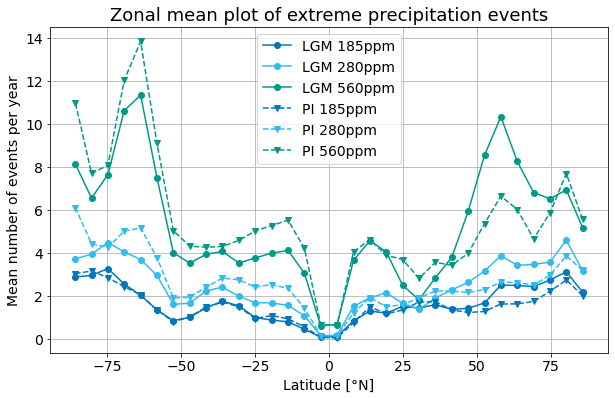

In [5]:
### zonal plots
#%matplotlib qt
import matplotlib

c1='#0077BB'
c2='#33BBEE'
c3='#009988'
lbls=14
matplotlib.rc('xtick', labelsize=lbls) 
matplotlib.rc('ytick', labelsize=lbls) 
print(np.shape(events185_LGM))
#fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,figsize=(12,10))
plt.figure(figsize=(10,6))
plt.plot(lat,np.mean(events185_LGM,axis=1)/10,'o-',color=c1,label='LGM 185ppm')
plt.plot(lat,np.mean(events280_LGM,axis=1)/10,'o-',color=c2,label='LGM 280ppm')
plt.plot(lat,np.mean(events560_LGM,axis=1)/10,'o-',color=c3,label='LGM 560ppm')
plt.plot(lat,np.mean(events185_PI,axis=1)/10,'v--',color=c1,label='PI 185ppm')
plt.plot(lat,np.mean(events280_PI,axis=1)/10,'v--',color=c2,label='PI 280ppm')
plt.plot(lat,np.mean(events560_PI,axis=1)/10,'v--',color=c3,label='PI 560ppm')
plt.xlabel('Latitude [°N]',fontsize=14)
plt.legend(fontsize=14)
plt.ylabel('Mean number of events per year',fontsize=14)
plt.title('Zonal mean plot of extreme precipitation events',fontsize=18)
plt.grid()
plt.savefig('figures/zonal_mean.pdf')

In [6]:
#Compute global mean from lat-long grid
def calc_gmt(events,lat):
    # average along longitude
    events_long = np.mean(events,axis=1)
    # define weights according to latitude
    w = np.cos(np.deg2rad(lat))
    gmt = np.average(events_long,weights=w,axis=0)
    return gmt

GMT_185_LGM = calc_gmt(events185_LGM,lat=lat)
GMT_280_LGM = calc_gmt(events280_LGM,lat=lat)
GMT_560_LGM = calc_gmt(events560_LGM,lat=lat)
GMT_LGM = np.array([GMT_185_LGM,GMT_280_LGM,GMT_560_LGM])

GMT_185_PI = calc_gmt(events185_PI,lat=lat)
GMT_280_PI = calc_gmt(events280_PI,lat=lat)
GMT_560_PI = calc_gmt(events560_PI,lat=lat)
GMT_PI = np.array([GMT_185_PI,GMT_280_PI,GMT_560_PI])


#CO2 array
CO2 = np.array([185,280,560])
print(GMT_185_LGM)


13.028926048276103


In [7]:
weight = np.cos(np.deg2rad(lat))
weight_arr=np.zeros((32,64))
for i in range(64):
    weight_arr[:,i]=weight
    
weight_sum=(np.sum(weight_arr)/(32*64))

weighted185_LGM=np.mean((weight_arr*events185_LGM)/weight_sum)
err185_LGM=(np.std(weight_arr*events185_LGM)/weight_sum/np.sqrt(32*64))
weighted280_LGM=np.mean((weight_arr*events280_LGM)/weight_sum)
err280_LGM=(np.std(weight_arr*events280_LGM)/weight_sum/np.sqrt(32*64))
weighted560_LGM=np.mean((weight_arr*events560_LGM)/weight_sum)
err560_LGM=(np.std(weight_arr*events560_LGM)/weight_sum/np.sqrt(32*64))

weighted185_PI=np.mean((weight_arr*events185_PI)/weight_sum)
err185_PI=(np.std(weight_arr*events185_PI)/weight_sum/np.sqrt(32*64))
weighted280_PI=np.mean((weight_arr*events280_PI)/weight_sum)
err280_PI=(np.std(weight_arr*events280_PI)/weight_sum/np.sqrt(32*64))
weighted560_PI=np.mean((weight_arr*events560_PI)/weight_sum)
err560_PI=(np.std(weight_arr*events560_PI)/weight_sum/np.sqrt(32*64))

In [8]:
from scipy.optimize import curve_fit

def gerade(x,a,b):
    return a*x+b
popt,pcov=curve_fit(gerade,CO2,GMT_LGM/10,sigma=np.array([err185_LGM,err280_LGM,err560_LGM])/10)
popt2,pcov2=curve_fit(gerade,CO2,GMT_PI/10,sigma=np.array([err185_PI,err280_PI,err560_PI])/10)
perr=np.sqrt(np.diag(pcov))
perr2=np.sqrt(np.diag(pcov2))
popt,perr

(array([ 0.00811666, -0.20943805]), array([0.00030568, 0.07350559]))

linear trend: 0.812±0.031 [events/100ppm]
linear trend: 0.9286±0.0255 [events/100ppm]


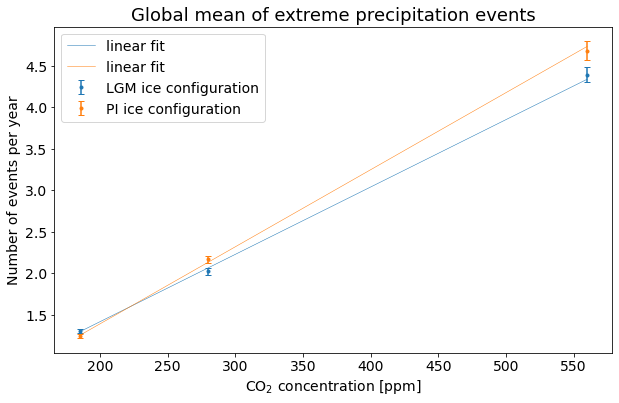

In [34]:
plt.figure(figsize=(10,6))
plt.errorbar(CO2,GMT_LGM/10,np.array([err185_LGM,err280_LGM,err560_LGM])/10,linestyle='None',marker='.',capsize=3,label='LGM ice configuration')
plt.errorbar(CO2,GMT_PI/10,np.array([err185_PI,err280_PI,err560_PI])/10,linestyle='None',marker='.',capsize=3,label='PI ice configuration')
plt.plot(CO2,gerade(CO2,*popt),color='tab:blue',linewidth=.5,label='linear fit')
plt.plot(CO2,gerade(CO2,*popt2),color='tab:orange',linewidth=.5,label='linear fit')

plt.title('Global mean of extreme precipitation events',fontsize=18)
plt.ylabel('Number of events per year',fontsize=14)
plt.xlabel('CO$_2$ concentration [ppm]',fontsize=14)
plt.legend(fontsize=14)
plt.savefig('figures/global_mean.pdf')

print('linear trend: '+str(np.round(popt[0]*100,3))+'±'+str(np.round(perr[0]*100,3))+' [events/100ppm]')
print('linear trend: '+str(np.round(popt2[0]*100,4))+'±'+str(np.round(perr2[0]*100,4))+' [events/100ppm]')

In [10]:
#Creation of a netCDF file to store the data, since the calculations take very long.
#We found http://pyhogs.github.io/intro_netcdf4.html for how to create a netCDF file and used that.

#Setup the file
#f = Dataset('output/events.nc', 'w', format='NETCDF4') #'w' stands for write
#prgrp = f.createGroup('events_data') #Create a group

#Create dimensions
#prgrp.createDimension('lat', len(lat))
#prgrp.createDimension('lon', len(lon))

#Create variables with those dimensions
#latitude = prgrp.createVariable('Latitude', 'f4', 'lat')
#longitude = prgrp.createVariable('Longitude', 'f4', 'lon')
#nEvents185_LGM = prgrp.createVariable('nEvents185_LGM', 'f4', ('lat', 'lon'))
#nEvents280_LGM = prgrp.createVariable('nEvents280_LGM', 'f4', ('lat', 'lon'))
#nEvents560_LGM = prgrp.createVariable('nEvents560_LGM', 'f4', ('lat', 'lon'))
#nEvents185_PI = prgrp.createVariable('nEvents185_PI', 'f4', ('lat', 'lon'))
#nEvents280_PI = prgrp.createVariable('nEvents280_PI', 'f4', ('lat', 'lon'))
#nEvents560_PI = prgrp.createVariable('nEvents560_PI', 'f4', ('lat', 'lon'))

#Now the variables can be filled
#longitude[:] = lon #The "[:]" at the end of the variable instance is necessary
#latitude[:] = lat
#nEvents185_LGM[:,:] = events185_LGM
#nEvents280_LGM[:,:] = events280_LGM
#nEvents560_LGM[:,:] = events560_LGM
#nEvents185_PI[:,:] = events185_PI
#nEvents280_PI[:,:] = events280_PI
#nEvents560_PI[:,:] = events560_PI

#Add global attributes
#f.description = "number of daily extreme precipitation events for different C02 and ice configurations; events<'CO2'>_<'ice'>"
#from datetime import datetime
#today = datetime.today()
#f.history = "Created " + today.strftime("%d/%m/%y")

#Add local attributes to variable instances
#latitude.units = 'degrees_north'
#longitude.units = 'degrees_east'

#f.close()

In [11]:
#To load it in again:

#SaveFile = Dataset('Events.nc','r')
#Group = SaveFile.groups['Events_data']

#nEvents_LGM_185 = Group.variables['NoE_LGM_185'][:]
#nEvents_LGM_280 = Group.variables['NoE_LGM_280'][:]
#nEvents_LGM_560 = Group.variables['NoE_LGM_560'][:]
#nEvents_PI_185 = Group.variables['NoE_PI_185'][:]
#nEvents_PI_280 = Group.variables['NoE_PI_280'][:]
#nEvents_PI_560 = Group.variables['NoE_PI_560'][:]
#lat  = Group.variables['Latitude'][:]
#lon  = Group.variables['Longitude'][:]

### Now the maps are created

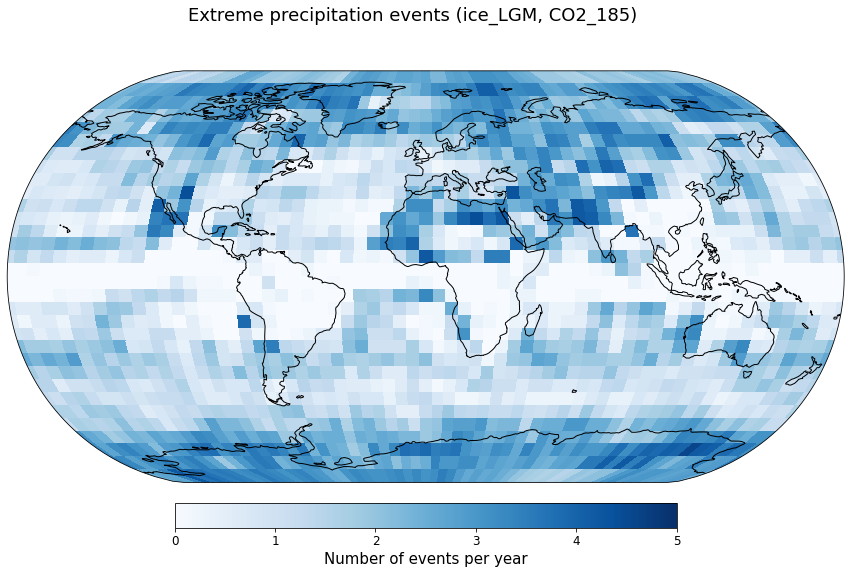

In [12]:
#Plot a map of the events. Change here the event array:
events = events185_LGM
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la = np.meshgrid(lon_plot,lat)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues',shading='nearest',vmax=5)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
fig.suptitle('Extreme precipitation events (ice_LGM, CO2_185)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=0.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)

plt.savefig("figures/events185_LGM.jpg",format="jpg",dpi=300)

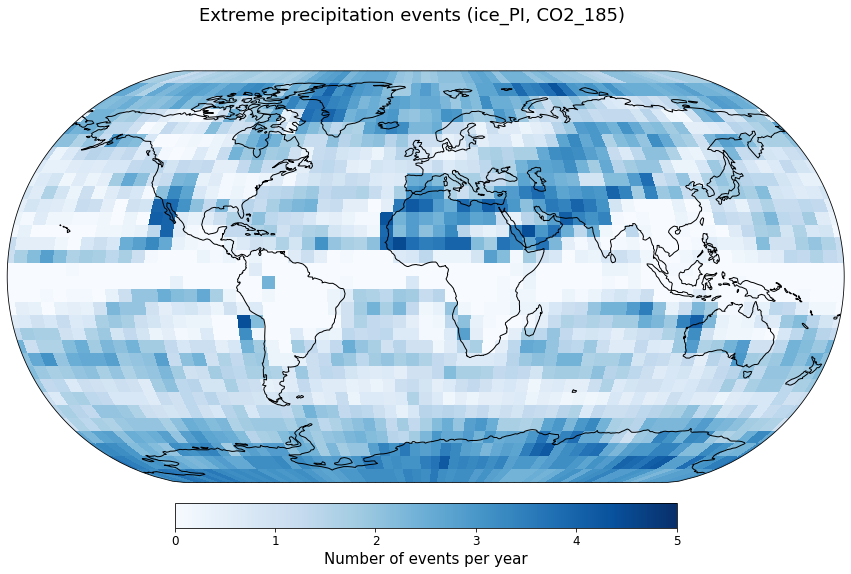

In [13]:
#Plot a map of the events. Change here the event array:
events = events185_PI
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la = np.meshgrid(lon_plot,lat)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues',shading='nearest',vmax=5)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
plt.suptitle('Extreme precipitation events (ice_PI, CO2_185)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)
plt.savefig("figures/events185_PI.jpg",format="jpg",dpi=300)

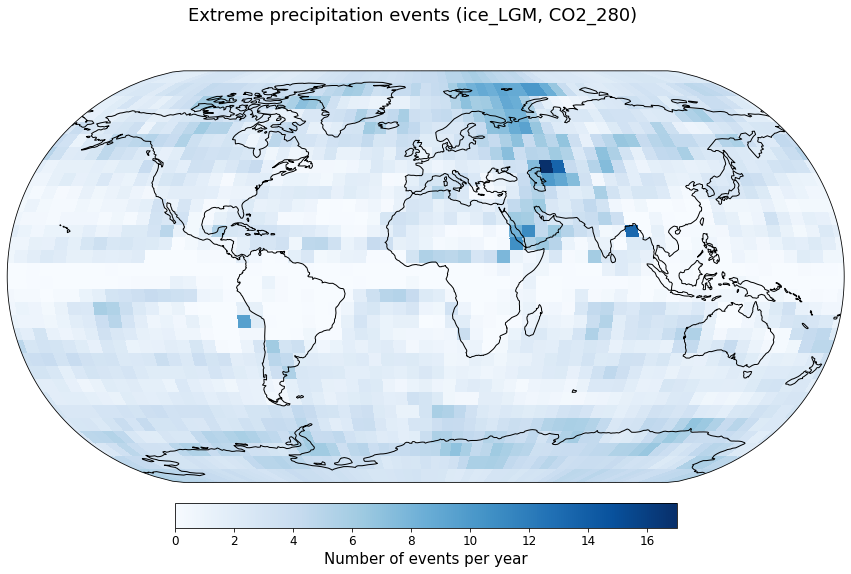

In [14]:
#Plot a map of the events. Change here the event array:
events = events280_LGM
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la = np.meshgrid(lon_plot,lat)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues',shading='nearest',vmax=17)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
plt.suptitle('Extreme precipitation events (ice_LGM, CO2_280)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)

plt.savefig("figures/events280_LGM.jpg",format="jpg",dpi=300)

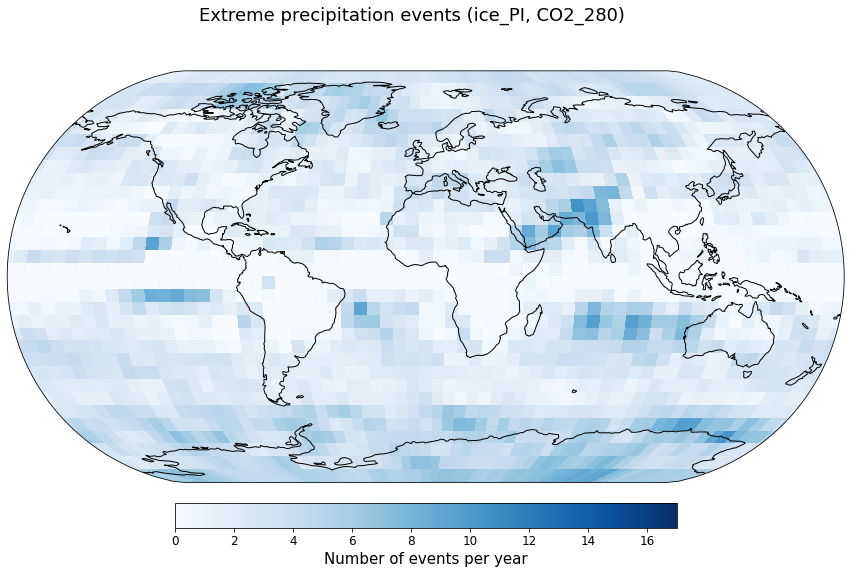

In [15]:
#Plot a map of the events. Change here the event array:
events = events280_PI
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la = np.meshgrid(lon_plot,lat)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues',shading='nearest',vmax=17)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
plt.suptitle('Extreme precipitation events (ice_PI, CO2_280)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)

plt.savefig("figures/events280_PI.jpg",format="jpg",dpi=300)

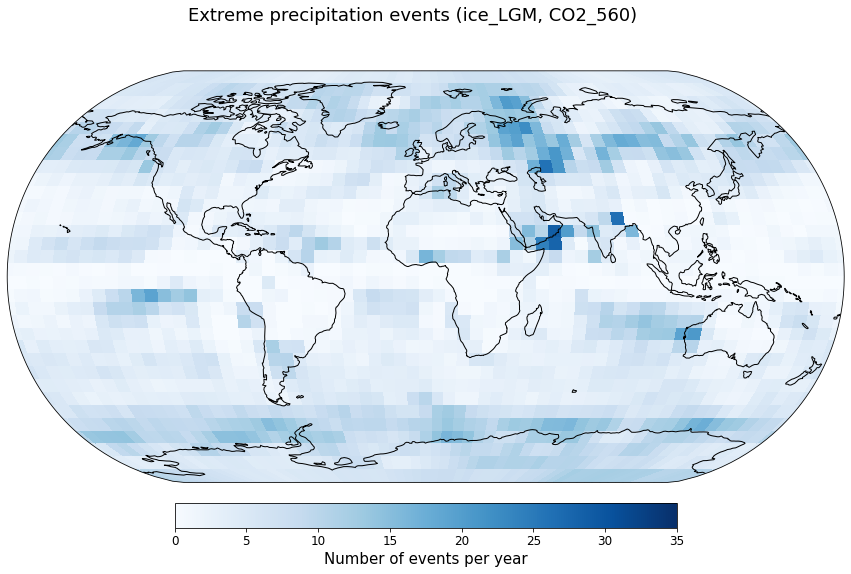

In [16]:
#Plot a map of the events. Change here the event array:
events = events560_LGM
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la = np.meshgrid(lon_plot,lat)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues',shading='nearest',vmax=35)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
plt.suptitle('Extreme precipitation events (ice_LGM, CO2_560)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)

plt.savefig("figures/events560_LGM.jpg",format="jpg",dpi=300)

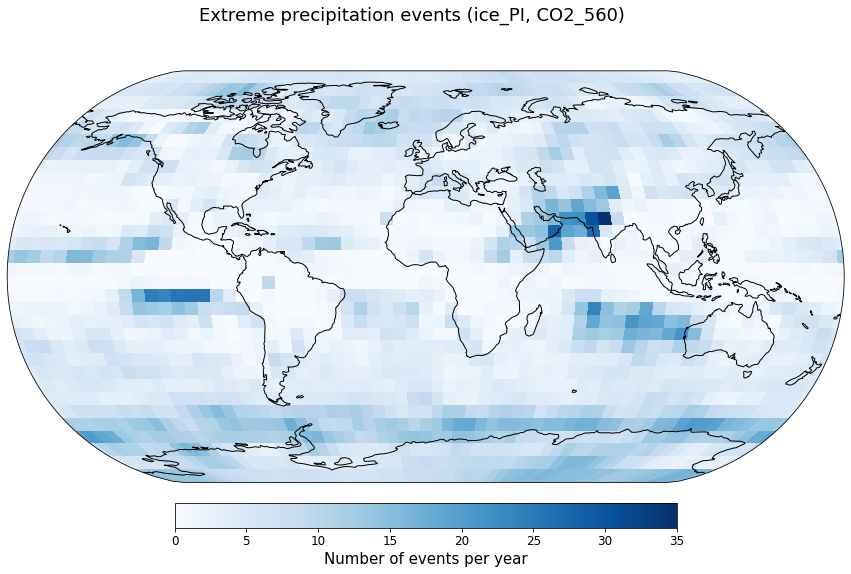

In [17]:
#Plot a map of the events. Change here the event array:
events = events560_PI
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la = np.meshgrid(lon_plot,lat)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues',shading='nearest',vmax=35)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
plt.suptitle('Extreme precipitation events (ice_PI, CO2_560)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)

plt.savefig("figures/events560_PI.jpg",format="jpg",dpi=300)

## Comparison between the simulations

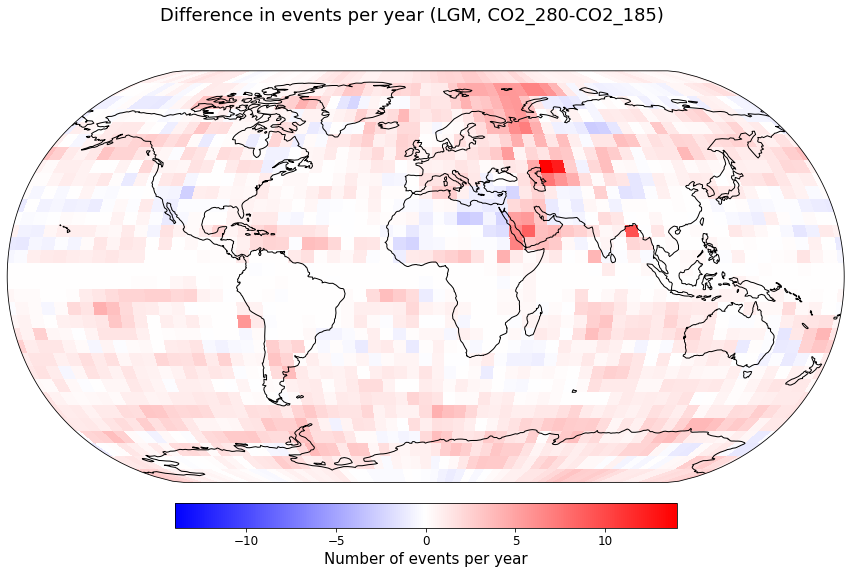

In [18]:
#Plot a map of the events. Change here the event array:
events = events280_LGM - events185_LGM
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la=np.meshgrid(lon_plot,lat)

#Fix center of colorbar to 0
#import matplotlib.colors as mcolors
#norm = mcolors.DivergingNorm(vcenter=0,vmin=-14,vmax=14)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='bwr',shading='nearest',vmin=-14,vmax=14)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
plt.suptitle('Difference in events per year (LGM, CO2_280-CO2_185)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)

plt.savefig("figures/difference280-185_LGM.jpg",format="jpg",dpi=300)

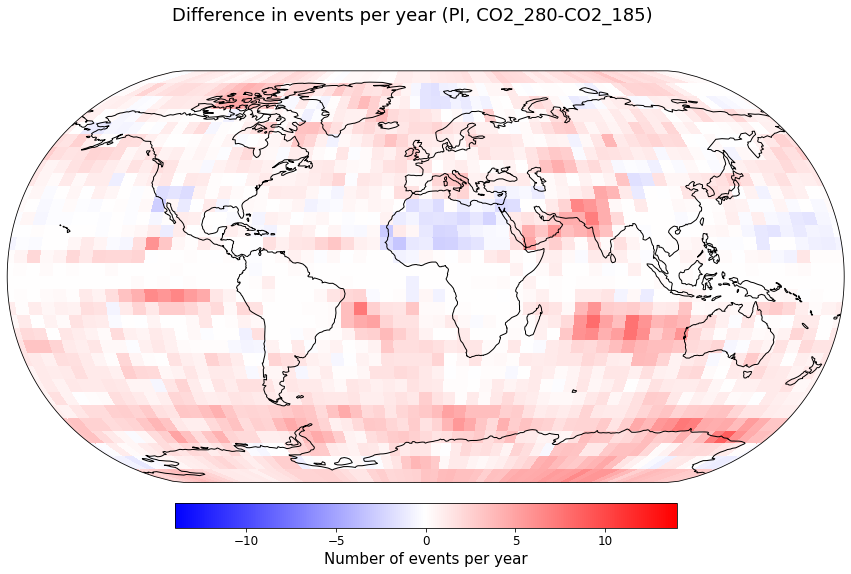

In [19]:
#Plot a map of the events. Change here the event array:
events = events280_PI - events185_PI
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la=np.meshgrid(lon_plot,lat)

#Fix center of colorbar to 0
#import matplotlib.colors as mcolors
#norm = mcolors.DivergingNorm(vcenter=0,vmin=-14,vmax=14)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='bwr',shading='nearest',vmin=-14,vmax=14)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
plt.suptitle('Difference in events per year (PI, CO2_280-CO2_185)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)

plt.savefig("figures/difference280-185_PI_samescale.jpg",format="jpg",dpi=300)

## Here comes our key plot for this task (and the presentation)

- For the presentation key plot we choose the following one (the difference between CO2_560 and CO2_185), because the change is strongest visible.

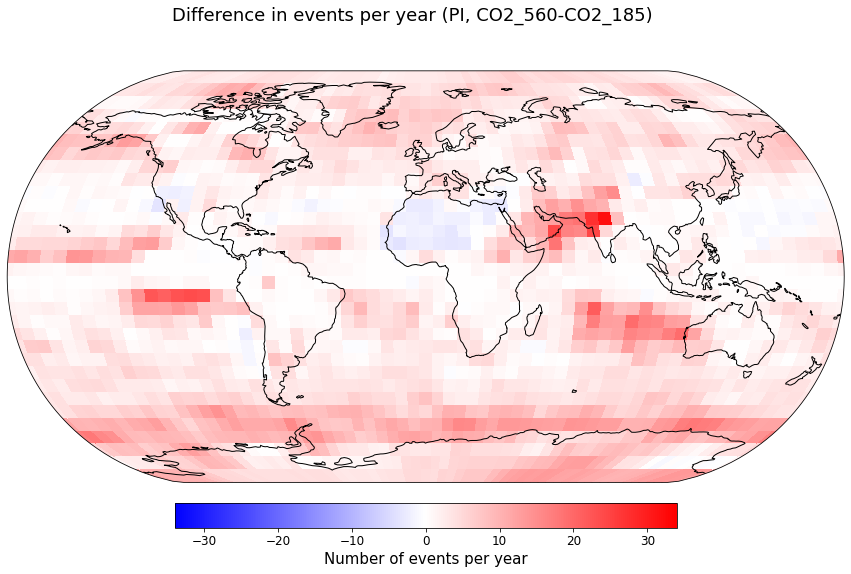

In [20]:
#Plot a map of the events. Change here the event array:
events = events560_PI - events185_PI
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la=np.meshgrid(lon_plot,lat)

#Fix center of colorbar to 0
#import matplotlib.colors as mcolors
#norm = mcolors.DivergingNorm(vcenter=0,vmin=-14,vmax=14)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='bwr',shading='nearest',vmin=-34,vmax=34)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
fig.suptitle('Difference in events per year (PI, CO2_560-CO2_185)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)

plt.savefig("figures/difference560-185_PI.jpg",format="jpg",dpi=300)

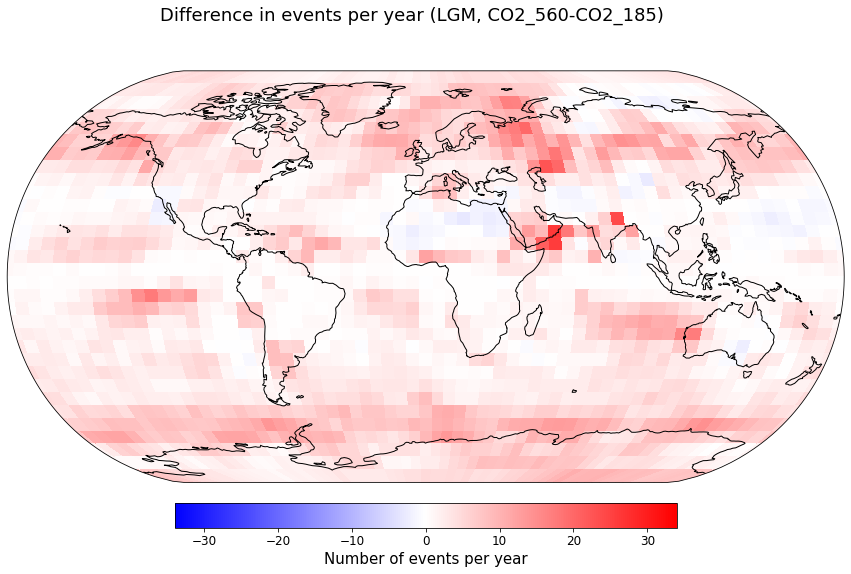

In [21]:
#Plot a map of the events. Change here the event array:
events = events560_LGM - events185_LGM
events = events/10 #Events per year

#Remove white line
events, lon_plot = add_cyclic_point(events, coord=lon)
lo,la=np.meshgrid(lon_plot,lat)

#Fix center of colorbar to 0
#import matplotlib.colors as mcolors
#norm = mcolors.DivergingNorm(vcenter=0,vmin=-14,vmax=14)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.EckertIII())
ax.coastlines()
#ax.gridlines()
#ax.stock_img()
ctf = ax.pcolormesh(lo, la, events, transform=ccrs.PlateCarree(),cmap='bwr',shading='nearest',vmin=-34,vmax=34)
#ctf=ax.contourf(lo, la, events, transform=ccrs.PlateCarree(),cmap='Blues')#shading='nearest')
fig.suptitle('Difference in events per year (LGM, CO2_560-CO2_185)',fontsize=18,y=.85)
cb=fig.colorbar(ctf,orientation='horizontal',shrink=0.6,pad=.03)
cb.set_label("Number of events per year",size=15)
cb.ax.tick_params(labelsize='large')
plt.subplots_adjust(bottom=0.02,top=.96)

plt.savefig("figures/difference560-185_LGM_samescale.jpg",format="jpg",dpi=300)

### create plots for visualization of method to determine number of extreme events

52.6065260343453 °N
11.25 °E


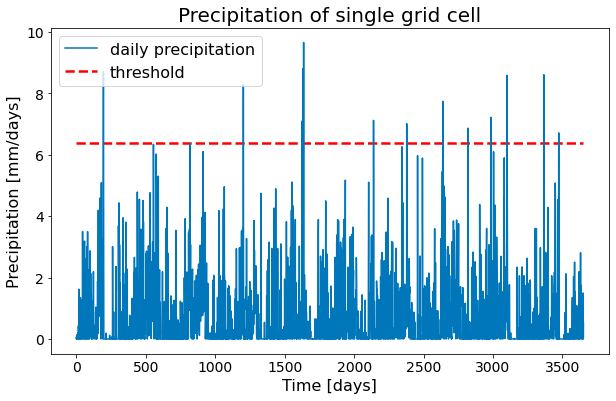

In [32]:
point_lat = 6
point_lon = 2
hline = mean185_LGM[point_lat,point_lon] + 5*std185_LGM[point_lat,point_lon]
c1='#0077BB'
time = np.arange(0,3652,1)
pr = pr185_LGM[:,point_lat,point_lon] *60*60*24 *1000

plt.figure(figsize=(10,6))
plt.plot(time,pr,label="daily precipitation",color=c1)
plt.xlabel("Time [days]",fontsize=16)
plt.ylabel("Precipitation [mm/days]", fontsize=16)
#plt.title("Precipitation at "+str(np.round(lat[point_lat],2))+"°N and "+str(np.round(lon[point_lon],2))+"°E",fontsize=18)
plt.title("Precipitation of single grid cell",fontsize=20)
plt.hlines(hline *60*60*24 *1000,time[0],time[-1],color="red",ls="--",lw=2.5,label="threshold")
plt.legend(fontsize=16,loc="upper left")
plt.savefig("figures/threshold_example.pdf",format="pdf")
print(lat[point_lat],"°N")
print(lon[point_lon],"°E")

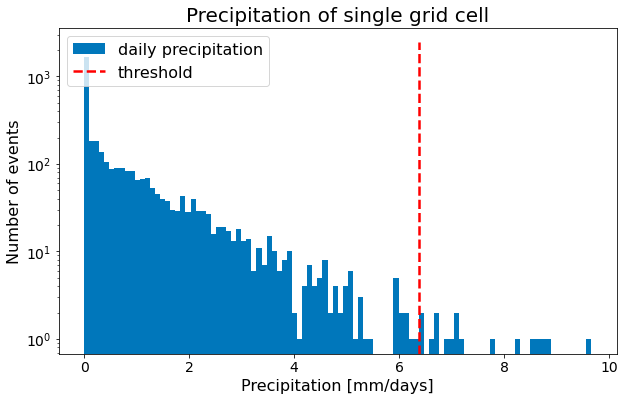

In [33]:
plt.figure(figsize=(10,6))
plt.hist(pr,bins=100,color=c1,label="daily precipitation")
plt.yscale("log")
bottom, top = plt.ylim()
plt.vlines(hline *60*60*24 *1000,bottom-1,top,color="red",ls="--",lw=2.5,label="threshold")
plt.ylabel("Number of events",fontsize=16)
plt.xlabel("Precipitation [mm/days]", fontsize=16)
plt.title("Precipitation of single grid cell",fontsize=20)
plt.legend(fontsize=16,loc='upper left')
plt.savefig("figures/threshold_histo.pdf",format="pdf")